In [1]:
# torch and torchvision imports



from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
from transformer import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


2023-12-08 17:01:41.297721: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 17:01:41.326791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 17:01:41.326825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 17:01:41.327611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 17:01:41.332641: I tensorflow/core/platform/cpu_feature_guar

Device: cuda


### Loading and Preparing Data

In [2]:
X_train = torch.from_numpy(np.transpose(np.load('./data/X_train.npz')['arr_0'], axes = (0,2,1))).float()
X_test = torch.from_numpy(np.transpose(np.load('./data/X_val.npz')['arr_0'], axes = (0,2,1))).float()
y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()
y_test = pd.read_csv('./data/Y_val.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()

/tmp/ipykernel_229097/265309155.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()


In [3]:
y_train = torch.from_numpy(y_train).int()
y_test = torch.from_numpy(y_test).int()

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
x = X_train[0:1]
print(x.shape)

torch.Size([1, 12, 1000])


### Creating the Resnet Model

In [5]:
"""Transformer needs X input as (seq_len, batch_size, channels)"""
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
# resnetModel = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)

# resnetModel(X_train[0:1].to(device))
print(summary(model.to(device), (1,12, 200)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 6]                    --
├─Conv1d: 1-1                            [1, 64, 100]              5,376
├─ReLU: 1-2                              [1, 64, 100]              --
├─BatchNorm1d: 1-3                       [1, 64, 100]              128
├─MaxPool1d: 1-4                         [1, 64, 50]               --
├─Sequential: 1-5                        [1, 256, 50]              --
│    └─Bottleneck: 2-1                   [1, 256, 50]              --
│    │    └─Conv1d: 3-1                  [1, 64, 50]               4,096
│    │    └─ReLU: 3-2                    [1, 64, 50]               --
│    │    └─BatchNorm1d: 3-3             [1, 64, 50]               128
│    │    └─Conv1d: 3-4                  [1, 64, 50]               12,288
│    │    └─ReLU: 3-5                    [1, 64, 50]               --
│    │    └─BatchNorm1d: 3-6             [1, 64, 50]               128
│ 

In [6]:
(4*1024-23.86)/124.66 #Max batch size

32.66597144232312

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle=True)

In [6]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=3, average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [9]:
criterion = nn.BCELoss()
epochs = 10
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=3).to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

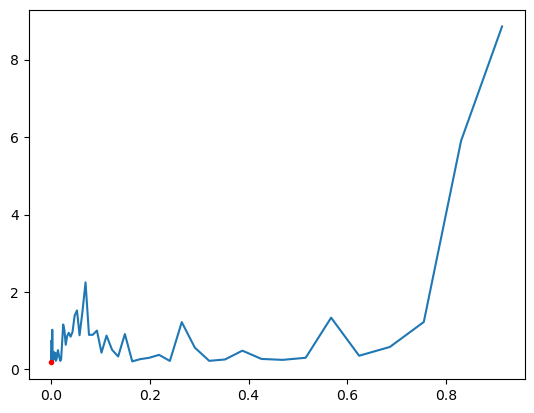

In [10]:
train_loss = []
lrs = []

for i, (signal, labels) in enumerate(train_loader):
    idx = np.random.randint(0, 1000-200)
    signal = (signal[:, :, idx:idx+200]).to(device)
    labels = labels.to(device)
    output = model(signal)
    loss = criterion(output, labels.float())
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    lrs.append(lr)
    lr *= 1.1

    for g in optimizer.param_groups:
        g['lr'] = lr 

    optimizer.step()

    if i > 200 or lr > 1:
        break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


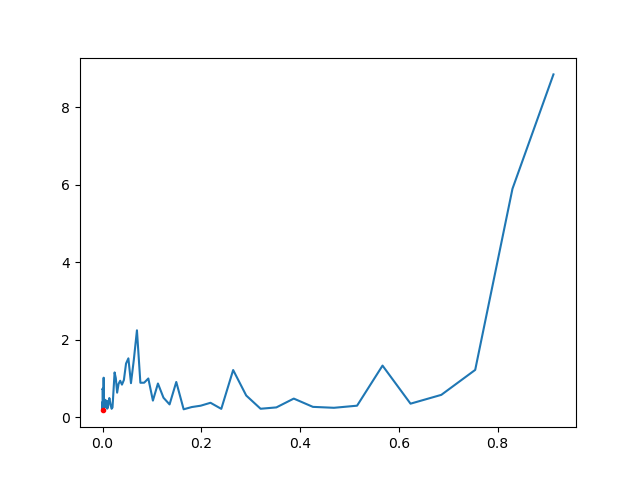

In [11]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

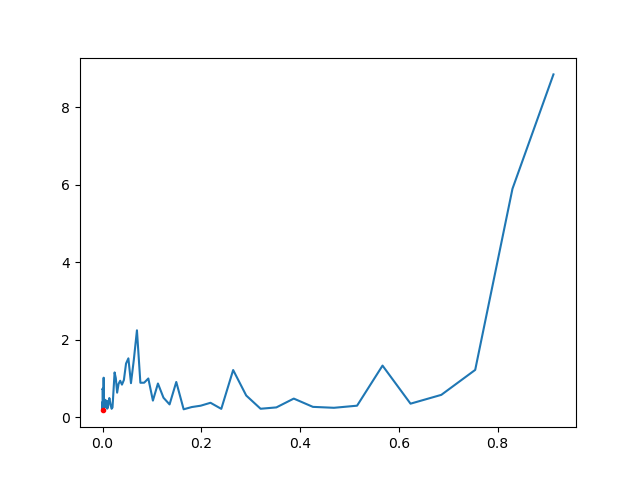

In [12]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [13]:
lr_max

array([0.00020797])

In [7]:
lr_max = 0.0003/10
lr = lr_max
epochs = 100
criterion = nn.BCELoss()
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

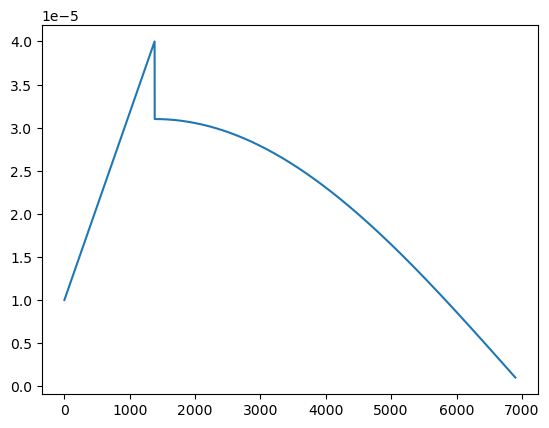

In [8]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-5) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [9]:
lr =lr_max

In [10]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        idx = np.random.randint(0, 1000-200)
        signal_sample = (signal[:, :, idx:idx+200]).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal_sample)
        loss = criterion(outputs, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%(len(train_loader)//10) == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            idx = np.random.randint(0, 1000-200)
            signal = (signal[:, :, idx:idx+200]).to(device)
            labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

Step: 1/69  |  Train loss: 0.7543  |  Train AUC: 0.5023
Step: 7/69  |  Train loss: 0.3516  |  Train AUC: 0.5274
Step: 13/69  |  Train loss: 0.3085  |  Train AUC: 0.5899
Step: 19/69  |  Train loss: 0.2878  |  Train AUC: 0.5991
Step: 25/69  |  Train loss: 0.2150  |  Train AUC: 0.7439
Step: 31/69  |  Train loss: 0.2168  |  Train AUC: 0.7063
Step: 37/69  |  Train loss: 0.2510  |  Train AUC: 0.6771
Step: 43/69  |  Train loss: 0.2096  |  Train AUC: 0.6751
Step: 49/69  |  Train loss: 0.2756  |  Train AUC: 0.6486
Step: 55/69  |  Train loss: 0.2524  |  Train AUC: 0.6900
Step: 61/69  |  Train loss: 0.2423  |  Train AUC: 0.7185
Step: 67/69  |  Train loss: 0.2343  |  Train AUC: 0.6433


/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 1/69  |  Train loss: 0.2540  |  Train AUC: 0.7334
Step: 7/69  |  Train loss: 0.3053  |  Train AUC: 0.6319
Step: 13/69  |  Train loss: 0.2293  |  Train AUC: 0.6893
Step: 19/69  |  Train loss: 0.2149  |  Train AUC: 0.5353
Step: 25/69  |  Train loss: 0.2625  |  Train AUC: 0.7101
Step: 31/69  |  Train loss: 0.2167  |  Train AUC: 0.7022
Step: 37/69  |  Train loss: 0.1961  |  Train AUC: 0.6936
Step: 43/69  |  Train loss: 0.2420  |  Train AUC: 0.6387
Step: 49/69  |  Train loss: 0.2648  |  Train AUC: 0.7213
Step: 55/69  |  Train loss: 0.2320  |  Train AUC: 0.5952
Step: 61/69  |  Train loss: 0.2134  |  Train AUC: 0.3889
Step: 67/69  |  Train loss: 0.2831  |  Train AUC: 0.6553
Step: 1/69  |  Train loss: 0.2173  |  Train AUC: 0.6828
Step: 7/69  |  Train loss: 0.2900  |  Train AUC: 0.6507
Step: 13/69  |  Train loss: 0.2273  |  Train AUC: 0.6411
Step: 19/69  |  Train loss: 0.2608  |  Train AUC: 0.6455
Step: 25/69  |  Train loss: 0.2671  |  Train AUC: 0.6945
Step: 31/69  |  Train loss: 0.2135 

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 1/69  |  Train loss: 0.2058  |  Train AUC: 0.8417
Step: 7/69  |  Train loss: 0.2143  |  Train AUC: 0.8304
Step: 13/69  |  Train loss: 0.2099  |  Train AUC: 0.8297
Step: 19/69  |  Train loss: 0.2337  |  Train AUC: 0.8463
Step: 25/69  |  Train loss: 0.1877  |  Train AUC: 0.8489
Step: 31/69  |  Train loss: 0.2424  |  Train AUC: 0.8178
Step: 37/69  |  Train loss: 0.2575  |  Train AUC: 0.8011
Step: 43/69  |  Train loss: 0.2320  |  Train AUC: 0.7771
Step: 49/69  |  Train loss: 0.2232  |  Train AUC: 0.7662
Step: 55/69  |  Train loss: 0.2411  |  Train AUC: 0.7807
Step: 61/69  |  Train loss: 0.2048  |  Train AUC: 0.8508
Step: 67/69  |  Train loss: 0.2257  |  Train AUC: 0.7595
Step: 1/69  |  Train loss: 0.1605  |  Train AUC: 0.8515
Step: 7/69  |  Train loss: 0.1954  |  Train AUC: 0.8464
Step: 13/69  |  Train loss: 0.2187  |  Train AUC: 0.7753
Step: 19/69  |  Train loss: 0.2192  |  Train AUC: 0.7968
Step: 25/69  |  Train loss: 0.2022  |  Train AUC: 0.8622
Step: 31/69  |  Train loss: 0.1828 

In [ ]:
signal.shape

In [ ]:
with open('superclassresnetmodel.pickle', 'wb') as f:
    pickle.dump(model, f)

In [5]:
import pickle, matplotlib.pyplot as plt, torch
with open('./modelres/SuperClasslosses.pickle', 'rb') as f:
    train_losses = pickle.load(f)

In [6]:
len(train_losses)

3

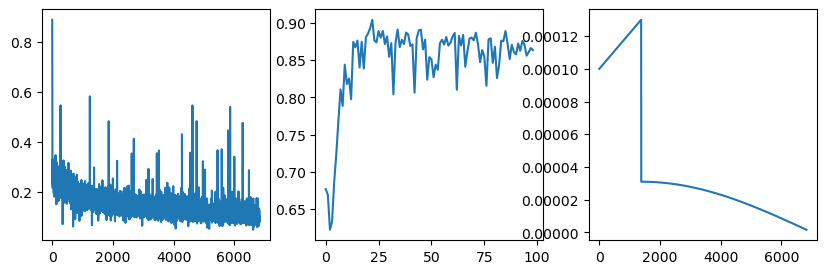

In [7]:
fig,axes = plt.subplots(1,3, figsize = (10,3))
axes[0].plot(train_losses[0])
axes[1].plot(torch.tensor(train_losses[1]))
axes[2].plot(train_losses[2])
plt.show()


In [12]:
torch.tensor(train_losses[0][-2000:]).mean()

tensor(0.1128)

In [11]:
import torch
torch.tensor(train_losses[1]).device

device(type='cpu')

In [12]:
train_losses[2]

[0.0001,
 0.00010002173913043479,
 0.00010004347826086956,
 0.00010006521739130435,
 0.00010008695652173914,
 0.00010010869565217392,
 0.0001001304347826087,
 0.00010015217391304348,
 0.00010017391304347827,
 0.00010019565217391304,
 0.00010021739130434783,
 0.00010023913043478262,
 0.00010026086956521739,
 0.00010028260869565218,
 0.00010030434782608696,
 0.00010032608695652174,
 0.00010034782608695652,
 0.00010036956521739131,
 0.0001003913043478261,
 0.00010041304347826087,
 0.00010043478260869566,
 0.00010045652173913044,
 0.00010047826086956522,
 0.0001005,
 0.00010052173913043479,
 0.00010054347826086958,
 0.00010056521739130435,
 0.00010058695652173914,
 0.00010060869565217392,
 0.0001006304347826087,
 0.00010065217391304348,
 0.00010067391304347827,
 0.00010069565217391304,
 0.00010071739130434783,
 0.00010073913043478262,
 0.00010076086956521739,
 0.00010078260869565218,
 0.00010080434782608696,
 0.00010082608695652175,
 0.00010084782608695652,
 0.00010086956521739131,
 0.0001

In [ ]:
model